In [ ]:
!git clone https://github.com/PhonePe/pulse.git

Cloning into 'pulse'...
remote: Enumerating objects: 17904, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 17904 (delta 19), reused 17 (delta 17), pack-reused 17855 (from 2)
Receiving objects: 100% (17904/17904), 26.13 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (8723/8723), done.
Updating files: 100% (9029/9029), done.


**Aggregated Data**

In [ ]:
import requests
import pandas as pd
from datetime import datetime

def fetch_data(folder_name):
    base_country_url = f"https://raw.githubusercontent.com/PhonePe/pulse/master/data/aggregated/{folder_name}/country/india"
    base_state_url = f"https://raw.githubusercontent.com/PhonePe/pulse/master/data/aggregated/{folder_name}/country/india/state"

    years = [str(y) for y in range(2018, 2025)]
    quarters = [f"{q}.json" for q in range(1, 5)]

    records = []

    # 1. COUNTRY-LEVEL DATA
    for year in years:
        for quarter_file in quarters:
            url = f"{base_country_url}/{year}/{quarter_file}"
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    data = response.json()
                    if data.get("success") and "transactionData" in data["data"]:
                        for transaction in data["data"]["transactionData"]:
                            for payment in transaction.get("paymentInstruments", []):
                                from_date = datetime.fromtimestamp(data["data"]["from"] / 1000.0)
                                to_date = datetime.fromtimestamp(data["data"]["to"] / 1000.0)
                                response_timestamp = datetime.fromtimestamp(data["responseTimestamp"] / 1000.0)

                                records.append({
                                    "source_type": folder_name,
                                    "level": "Country",
                                    "state_name": "null",
                                    "year": year,
                                    "quarter_file": quarter_file,
                                    "from_date": from_date.strftime("%Y-%m-%d"),
                                    "to_date": to_date.strftime("%Y-%m-%d"),
                                    "category": transaction.get("name", "null"),
                                    "payment_type": payment.get("type", "null"),
                                    "transaction_count": payment.get("count", "null"),
                                    "transaction_amount": payment.get("amount", "null"),
                                    "response_timestamp": response_timestamp.strftime("%Y-%m-%d %H:%M:%S"),
                                    "response_timestamp_epoch": data.get("responseTimestamp", "null"),
                                    "status": "Success"
                                })
                    else:
                        records.append({
                            "source_type": folder_name, "level": "Country", "state_name": "null",
                            "year": year, "quarter_file": quarter_file, "from_date": "null", "to_date": "null",
                            "category": "null", "payment_type": "null", "transaction_count": "null",
                            "transaction_amount": "null", "response_timestamp": "null",
                            "response_timestamp_epoch": "null", "status": "Error"
                        })
                else:
                    raise Exception("Status code not 200")
            except Exception as e:
                records.append({
                    "source_type": folder_name, "level": "Country", "state_name": "null",
                    "year": year, "quarter_file": quarter_file, "from_date": "null", "to_date": "null",
                    "category": "null", "payment_type": "null", "transaction_count": "null",
                    "transaction_amount": "null", "response_timestamp": "null",
                    "response_timestamp_epoch": "null", "status": "Error"
                })

    # 2. STATE-LEVEL DATA
    try:
        state_url = f"https://api.github.com/repos/PhonePe/pulse/contents/data/aggregated/{folder_name}/country/india/state"
        response = requests.get(state_url)
        state_names = [entry["name"] for entry in response.json() if entry["type"] == "dir"]
    except Exception as e:
        print("Error fetching state list:", e)
        state_names = []

    for state in state_names:
        for year in years:
            for quarter_file in quarters:
                url = f"{base_state_url}/{state}/{year}/{quarter_file}"
                try:
                    response = requests.get(url)
                    if response.status_code == 200:
                        data = response.json()
                        if data.get("success") and "transactionData" in data["data"]:
                            for transaction in data["data"]["transactionData"]:
                                for payment in transaction.get("paymentInstruments", []):
                                    from_date = datetime.fromtimestamp(data["data"]["from"] / 1000.0)
                                    to_date = datetime.fromtimestamp(data["data"]["to"] / 1000.0)
                                    response_timestamp = datetime.fromtimestamp(data["responseTimestamp"] / 1000.0)

                                    records.append({
                                        "source_type": folder_name,
                                        "level": "State",
                                        "state_name": state,
                                        "year": year,
                                        "quarter_file": quarter_file,
                                        "from_date": from_date.strftime("%Y-%m-%d"),
                                        "to_date": to_date.strftime("%Y-%m-%d"),
                                        "category": transaction.get("name", "null"),
                                        "payment_type": payment.get("type", "null"),
                                        "transaction_count": payment.get("count", "null"),
                                        "transaction_amount": payment.get("amount", "null"),
                                        "response_timestamp": response_timestamp.strftime("%Y-%m-%d %H:%M:%S"),
                                        "response_timestamp_epoch": data.get("responseTimestamp", "null"),
                                        "status": "Success"
                                    })
                        else:
                            raise Exception("Missing transactionData")
                    else:
                        raise Exception("Status code not 200")
                except Exception as e:
                    records.append({
                        "source_type": folder_name, "level": "State", "state_name": state,
                        "year": year, "quarter_file": quarter_file, "from_date": "null", "to_date": "null",
                        "category": "null", "payment_type": "null", "transaction_count": "null",
                        "transaction_amount": "null", "response_timestamp": "null",
                        "response_timestamp_epoch": "null", "status": "Error"
                    })

    return records

# Merging all folders' data
final_records = []
for folder in ["insurance", "transaction", "user"]:
    print(f"Fetching {folder} data...")
    final_records.extend(fetch_data(folder))

# Save to CSV
df = pd.DataFrame(final_records)
df.to_csv("aggregated_combined_with_state_data.csv", index=False)
print("Merged CSV created: aggregated_combined_with_state_data.csv")


Fetching insurance data...
Fetching transaction data...
Fetching user data...
Merged CSV created: aggregated_combined_with_state_data.csv


In [ ]:
df = pd.DataFrame(final_records)          # Step 1: Create the full DataFrame from all collected data

df.fillna("null", inplace=True)           # Step 2: Ensure no empty fields (fills any NaN with "null")

# Step 3: Save individual CSVs based on source_type
for folder in ["insurance", "transaction", "user"]:
    folder_df = df[df["source_type"] == folder]          # Filter rows of that type
    file_name = f"{folder}_aggregated_with_state_data.csv"
    folder_df.to_csv(file_name, index=False)
    print(f"CSV saved: {file_name}")

CSV saved: insurance_aggregated_with_state_data.csv
CSV saved: transaction_aggregated_with_state_data.csv
CSV saved: user_aggregated_with_state_data.csv


**MAP DATA**

In [ ]:
import requests
import pandas as pd
from datetime import datetime

def fetch_map_data(folder_name, subfolder=""):
    base_url = f"https://raw.githubusercontent.com/PhonePe/pulse/master/data/map/{folder_name}{('/' + subfolder) if subfolder else ''}/country/india"
    base_state_url = f"{base_url}/state"

    years = [str(y) for y in range(2018, 2025)]
    quarters = [f"{q}.json" for q in range(1, 5)]

    records = []

    # COUNTRY LEVEL
    for year in years:
        for quarter in quarters:
            url = f"{base_url}/{year}/{quarter}"
            try:
                res = requests.get(url)
                if res.status_code == 200:
                    data = res.json()
                    meta = data.get("data", {}).get("meta", {})
                    table_data = data.get("data", {}).get("data", {}).get("data", [])
                    for row in table_data:
                        record = {
                            "source_type": folder_name,
                            "subfolder": subfolder or "null",
                            "level": "Country",
                            "state_name": "null",
                            "year": year,
                            "quarter_file": quarter,
                            "latitude": row[0] if len(row) > 0 else "null",
                            "longitude": row[1] if len(row) > 1 else "null",
                            "metric": row[2] if len(row) > 2 else "null",
                            "label": row[3] if len(row) > 3 else "null",
                            "response_timestamp_epoch": data.get("responseTimestamp", "null"),
                            "status": "Success"
                        }
                        records.append(record)
                else:
                    raise Exception("Status code not 200")
            except Exception as e:
                records.append({
                    "source_type": folder_name,
                    "subfolder": subfolder or "null",
                    "level": "Country",
                    "state_name": "null",
                    "year": year,
                    "quarter_file": quarter,
                    "latitude": "null",
                    "longitude": "null",
                    "metric": "null",
                    "label": "null",
                    "response_timestamp_epoch": "null",
                    "status": "Error"
                })

    # STATE LEVEL
    try:
        state_folder_url = f"https://api.github.com/repos/PhonePe/pulse/contents/data/map/{folder_name}{('/' + subfolder) if subfolder else ''}/country/india/state"
        res = requests.get(state_folder_url)
        state_names = [entry["name"] for entry in res.json() if entry["type"] == "dir"]
    except Exception as e:
        print("Failed to fetch state names:", e)
        state_names = []

    for state in state_names:
        for year in years:
            for quarter in quarters:
                url = f"{base_state_url}/{state}/{year}/{quarter}"
                try:
                    res = requests.get(url)
                    if res.status_code == 200:
                        data = res.json()
                        meta = data.get("data", {}).get("meta", {})
                        table_data = data.get("data", {}).get("data", {}).get("data", [])
                        for row in table_data:
                            record = {
                                "source_type": folder_name,
                                "subfolder": subfolder or "null",
                                "level": "State",
                                "state_name": state,
                                "year": year,
                                "quarter_file": quarter,
                                "latitude": row[0] if len(row) > 0 else "null",
                                "longitude": row[1] if len(row) > 1 else "null",
                                "metric": row[2] if len(row) > 2 else "null",
                                "label": row[3] if len(row) > 3 else "null",
                                "response_timestamp_epoch": data.get("responseTimestamp", "null"),
                                "status": "Success"
                            }
                            records.append(record)
                    else:
                        raise Exception("Status code not 200")
                except Exception as e:
                    records.append({
                        "source_type": folder_name,
                        "subfolder": subfolder or "null",
                        "level": "State",
                        "state_name": state,
                        "year": year,
                        "quarter_file": quarter,
                        "latitude": "null",
                        "longitude": "null",
                        "metric": "null",
                        "label": "null",
                        "response_timestamp_epoch": "null",
                        "status": "Error"
                    })

    return records

# Run for all three map folders
final_data = []
folders = [
    ("insurance", ""),
    ("transaction", "hover"),
    ("user", "hover")
]

for folder_name, subfolder in folders:
    print(f"Fetching map data for: {folder_name}/{subfolder}")
    final_data.extend(fetch_map_data(folder_name, subfolder))

# Save to CSV
df = pd.DataFrame(final_data)
df.to_csv("map_combined_data.csv", index=False)
print("✅ map_combined_data.csv generated successfully.")


Fetching map data for: insurance/
Fetching map data for: transaction/hover
Fetching map data for: user/hover
✅ map_combined_data.csv generated successfully.


In [ ]:
import requests
import pandas as pd
from datetime import datetime

def fetch_map_data(folder_name, subfolder=""):
    base_url = f"https://raw.githubusercontent.com/PhonePe/pulse/master/data/map/{folder_name}{('/' + subfolder) if subfolder else ''}/country/india"
    base_state_url = f"{base_url}/state"

    years = [str(y) for y in range(2018, 2025)]
    quarters = [f"{q}.json" for q in range(1, 5)]

    records = []

    def parse_data(data, level, state_name, year, quarter, folder_name):
        temp_records = []
        timestamp = data.get("responseTimestamp", "null")

        if folder_name == "insurance":
            table = data.get("data", {}).get("data", {}).get("data", [])
            for row in table:
                temp_records.append({
                    "source_type": folder_name,
                    "subfolder": subfolder or "null",
                    "level": level,
                    "state_name": state_name or "null",
                    "year": year,
                    "quarter_file": quarter,
                    "latitude": row[0] if len(row) > 0 else "null",
                    "longitude": row[1] if len(row) > 1 else "null",
                    "metric": row[2] if len(row) > 2 else "null",
                    "label": row[3] if len(row) > 3 else "null",
                    "response_timestamp_epoch": timestamp,
                    "status": "Success"
                })
        else:
            hover_data = data.get("data", {}).get("hoverDataList", [])
            for item in hover_data:
                metric = item.get("metric", {})
                temp_records.append({
                    "source_type": folder_name,
                    "subfolder": subfolder or "null",
                    "level": level,
                    "state_name": state_name or "null",
                    "year": year,
                    "quarter_file": quarter,
                    "latitude": "null",
                    "longitude": "null",
                    "metric": metric.get("amount", "null"),  # or "count" based on requirement
                    "label": item.get("name", "null"),
                    "response_timestamp_epoch": timestamp,
                    "status": "Success"
                })
        return temp_records

    # COUNTRY-LEVEL
    for year in years:
        for quarter in quarters:
            url = f"{base_url}/{year}/{quarter}"
            try:
                res = requests.get(url)
                if res.status_code == 200:
                    data = res.json()
                    records.extend(parse_data(data, "Country", None, year, quarter, folder_name))
                else:
                    raise Exception("Status code not 200")
            except Exception:
                records.append({
                    "source_type": folder_name,
                    "subfolder": subfolder or "null",
                    "level": "Country",
                    "state_name": "null",
                    "year": year,
                    "quarter_file": quarter,
                    "latitude": "null",
                    "longitude": "null",
                    "metric": "null",
                    "label": "null",
                    "response_timestamp_epoch": "null",
                    "status": "Error"
                })

    # STATE-LEVEL
    try:
        state_folder_url = f"https://api.github.com/repos/PhonePe/pulse/contents/data/map/{folder_name}{('/' + subfolder) if subfolder else ''}/country/india/state"
        res = requests.get(state_folder_url)
        state_names = [entry["name"] for entry in res.json() if entry["type"] == "dir"]
    except Exception:
        state_names = []

    for state in state_names:
        for year in years:
            for quarter in quarters:
                url = f"{base_state_url}/{state}/{year}/{quarter}"
                try:
                    res = requests.get(url)
                    if res.status_code == 200:
                        data = res.json()
                        records.extend(parse_data(data, "State", state, year, quarter, folder_name))
                    else:
                        raise Exception("Status code not 200")
                except Exception:
                    records.append({
                        "source_type": folder_name,
                        "subfolder": subfolder or "null",
                        "level": "State",
                        "state_name": state,
                        "year": year,
                        "quarter_file": quarter,
                        "latitude": "null",
                        "longitude": "null",
                        "metric": "null",
                        "label": "null",
                        "response_timestamp_epoch": "null",
                        "status": "Error"
                    })

    return records

# Save each map category into separate CSV
map_folders = [
    ("insurance", "insurance_map.csv"),
    ("transaction", "transaction_map.csv"),
    ("user", "user_map.csv")
]

for folder, filename in map_folders:
    print(f"Processing map folder: {folder}")
    data = fetch_map_data(folder, "hover" if folder != "insurance" else "")
    df = pd.DataFrame(data)
    df.fillna("null", inplace=True)
    df.to_csv(filename, index=False)
    print(f"✅ Saved to {filename}")


Processing map folder: insurance
✅ Saved to insurance_map.csv
Processing map folder: transaction
✅ Saved to transaction_map.csv
Processing map folder: user
✅ Saved to user_map.csv


**Top Data**

In [ ]:
import requests
import pandas as pd

def fetch_top_data(folder_name):
    base_url = f"https://raw.githubusercontent.com/PhonePe/pulse/master/data/top/{folder_name}/country/india"
    base_state_url = f"{base_url}/state"

    years = [str(y) for y in range(2018, 2025)]
    quarters = [f"{q}.json" for q in range(1, 5)]
    records = []

    def extract_entities(data, entity_type, level, state_name, year, quarter):
        results = []
        entities = data.get("data", {}).get(entity_type, [])
        for entity in entities:
            metric = entity.get("metric", {})
            results.append({
                "source_type": folder_name,
                "level": level,
                "state_name": state_name or "null",
                "year": year,
                "quarter_file": quarter,
                "entity_type": entity_type,
                "entity_name": entity.get("entityName", "null"),
                "metric_type": metric.get("type", "null"),
                "transaction_count": metric.get("count", "null"),
                "transaction_amount": metric.get("amount", "null"),
                "response_timestamp_epoch": data.get("responseTimestamp", "null"),
                "status": "Success"
            })
        return results

    # COUNTRY-LEVEL
    for year in years:
        for quarter in quarters:
            url = f"{base_url}/{year}/{quarter}"
            try:
                res = requests.get(url)
                if res.status_code == 200:
                    data = res.json()
                    for entity_type in ["states", "districts", "pincodes"]:
                        records.extend(extract_entities(data, entity_type, "Country", None, year, quarter))
                else:
                    raise Exception("Status code not 200")
            except Exception:
                for entity_type in ["states", "districts", "pincodes"]:
                    records.append({
                        "source_type": folder_name,
                        "level": "Country",
                        "state_name": "null",
                        "year": year,
                        "quarter_file": quarter,
                        "entity_type": entity_type,
                        "entity_name": "null",
                        "metric_type": "null",
                        "transaction_count": "null",
                        "transaction_amount": "null",
                        "response_timestamp_epoch": "null",
                        "status": "Error"
                    })

    # STATE-LEVEL
    try:
        state_folder_url = f"https://api.github.com/repos/PhonePe/pulse/contents/data/top/{folder_name}/country/india/state"
        res = requests.get(state_folder_url)
        state_names = [entry["name"] for entry in res.json() if entry["type"] == "dir"]
    except Exception:
        state_names = []

    for state in state_names:
        for year in years:
            for quarter in quarters:
                url = f"{base_state_url}/{state}/{year}/{quarter}"
                try:
                    res = requests.get(url)
                    if res.status_code == 200:
                        data = res.json()
                        for entity_type in ["states", "districts", "pincodes"]:
                            records.extend(extract_entities(data, entity_type, "State", state, year, quarter))
                    else:
                        raise Exception("Status code not 200")
                except Exception:
                    for entity_type in ["states", "districts", "pincodes"]:
                        records.append({
                            "source_type": folder_name,
                            "level": "State",
                            "state_name": state,
                            "year": year,
                            "quarter_file": quarter,
                            "entity_type": entity_type,
                            "entity_name": "null",
                            "metric_type": "null",
                            "transaction_count": "null",
                            "transaction_amount": "null",
                            "response_timestamp_epoch": "null",
                            "status": "Error"
                        })

    return records

# Combine all folders
final_records = []
for folder in ["insurance", "transaction", "user"]:
    print(f"Processing folder: {folder}")
    final_records.extend(fetch_top_data(folder))

# Save final merged data
df = pd.DataFrame(final_records)
df.fillna("null", inplace=True)
df.to_csv("top_combined_data.csv", index=False)
print("✅ Saved: top_combined_data.csv")


Processing folder: insurance
Processing folder: transaction
Processing folder: user
✅ Saved: top_combined_data.csv


In [ ]:
import requests
import pandas as pd

def fetch_top_data(folder_name):
    base_url = f"https://raw.githubusercontent.com/PhonePe/pulse/master/data/top/{folder_name}/country/india"
    base_state_url = f"{base_url}/state"

    years = [str(y) for y in range(2018, 2025)]
    quarters = [f"{q}.json" for q in range(1, 5)]

    records = []

    def extract_entities(data, entity_type, level, state_name, year, quarter):
        results = []
        entities = data.get("data", {}).get(entity_type, [])
        for entity in entities:
            metric = entity.get("metric", {})
            results.append({
                "source_type": folder_name,
                "level": level,
                "state_name": state_name or "null",
                "year": year,
                "quarter_file": quarter,
                "entity_type": entity_type,
                "entity_name": entity.get("entityName", "null"),
                "metric_type": metric.get("type", "null"),
                "transaction_count": metric.get("count", "null"),
                "transaction_amount": metric.get("amount", "null"),
                "response_timestamp_epoch": data.get("responseTimestamp", "null"),
                "status": "Success"
            })
        return results

    # COUNTRY-LEVEL
    for year in years:
        for quarter in quarters:
            url = f"{base_url}/{year}/{quarter}"
            try:
                res = requests.get(url)
                if res.status_code == 200:
                    data = res.json()
                    for entity_type in ["states", "districts", "pincodes"]:
                        records.extend(extract_entities(data, entity_type, "Country", None, year, quarter))
                else:
                    raise Exception("Status code not 200")
            except Exception:
                for entity_type in ["states", "districts", "pincodes"]:
                    records.append({
                        "source_type": folder_name,
                        "level": "Country",
                        "state_name": "null",
                        "year": year,
                        "quarter_file": quarter,
                        "entity_type": entity_type,
                        "entity_name": "null",
                        "metric_type": "null",
                        "transaction_count": "null",
                        "transaction_amount": "null",
                        "response_timestamp_epoch": "null",
                        "status": "Error"
                    })

    # STATE-LEVEL
    try:
        state_folder_url = f"https://api.github.com/repos/PhonePe/pulse/contents/data/top/{folder_name}/country/india/state"
        res = requests.get(state_folder_url)
        state_names = [entry["name"] for entry in res.json() if entry["type"] == "dir"]
    except Exception:
        state_names = []

    for state in state_names:
        for year in years:
            for quarter in quarters:
                url = f"{base_state_url}/{state}/{year}/{quarter}"
                try:
                    res = requests.get(url)
                    if res.status_code == 200:
                        data = res.json()
                        for entity_type in ["states", "districts", "pincodes"]:
                            records.extend(extract_entities(data, entity_type, "State", state, year, quarter))
                    else:
                        raise Exception("Status code not 200")
                except Exception:
                    for entity_type in ["states", "districts", "pincodes"]:
                        records.append({
                            "source_type": folder_name,
                            "level": "State",
                            "state_name": state,
                            "year": year,
                            "quarter_file": quarter,
                            "entity_type": entity_type,
                            "entity_name": "null",
                            "metric_type": "null",
                            "transaction_count": "null",
                            "transaction_amount": "null",
                            "response_timestamp_epoch": "null",
                            "status": "Error"
                        })

    return records

# Save to CSV for each category
top_folders = [
    ("insurance", "insurance_top.csv"),
    ("transaction", "transaction_top.csv"),
    ("user", "user_top.csv")
]

for folder, filename in top_folders:
    print(f"Processing top folder: {folder}")
    data = fetch_top_data(folder)
    df = pd.DataFrame(data)
    df.fillna("null", inplace=True)
    df.to_csv(filename, index=False)
    print(f"✅ Saved to {filename}")


Processing top folder: insurance
✅ Saved to insurance_top.csv
Processing top folder: transaction
✅ Saved to transaction_top.csv
Processing top folder: user
✅ Saved to user_top.csv


In [ ]:
!pip install pandas sqlalchemy pymysql


In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# MySQL credentials
user = 'root'
password = 'ilovesuga'
host = 'localhost'
port = 3306
database = 'phonepedb'

# Create the engine
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

# CSV files and target table names
csv_to_table = {
    'insurance_aggregated_with_state_data.csv': 'insurance_aggregated',
    'transaction_aggregated_with_state_data.csv': 'transaction_aggregated',
    'user_aggregated_with_state_data.csv': 'user_aggregated',
    'insurance_map.csv': 'insurance_map',
    'transaction_map.csv': 'transaction_map',
    'user_map_data.csv': 'user_map',
    'insurance_top.csv': 'insurance_top',
    'transaction_top.csv': 'transaction_top',
    'user_top.csv': 'user_top'
}

# Upload each CSV into SQL table
for csv_file, table_name in csv_to_table.items():
    try:
        df = pd.read_csv(csv_file)
        df.to_sql(table_name, con=engine, if_exists='replace', index=False)
        print(f"Successfully uploaded '{csv_file}' to table '{table_name}'")
    except Exception as e:
        print(f"Failed to upload '{csv_file}': {e}")


Failed to upload 'insurance_aggregated_with_state_data.csv': (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'localhost' ([Errno 99] Cannot assign requested address)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Failed to upload 'transaction_aggregated_with_state_data.csv': (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'localhost' ([Errno 99] Cannot assign requested address)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Failed to upload 'user_aggregated_with_state_data.csv': (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'localhost' ([Errno 99] Cannot assign requested address)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)


/tmp/ipython-input-11-1808781261.py:30: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Failed to upload 'insurance_map.csv': (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'localhost' ([Errno 99] Cannot assign requested address)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Failed to upload 'transaction_map.csv': (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'localhost' ([Errno 99] Cannot assign requested address)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Failed to upload 'user_map_data.csv': (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'localhost' ([Errno 99] Cannot assign requested address)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Failed to upload 'insurance_top.csv': (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on 'localhost' ([Errno 99] Cannot assign requested address)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Failed to upload 'transaction_top.csv': (pymysql.err.OperationalError) (2003, 

**Analysis**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load the CSVs from my SQL query results
# Case Study 1
df_txn_dynamics = pd.read_csv("case1_transaction_dynamics.csv")

# Case Study 3
df_insurance_growth = pd.read_csv("case3_insurance_growth.csv")

# Case Study 4
df_txn_market_expansion = pd.read_csv("case4_market_expansion1.csv")
df_txn_market_expansion = pd.read_csv("case4_market_expansion2.csv")
# Case Study 6
df_insurance_engagement = pd.read_csv("case6_insurance_engagement.csv")

# Case Study 7
df_txn_top_states = pd.read_csv("case7_top_states.csv")


Case Study 1: Decoding Transaction Dynamics

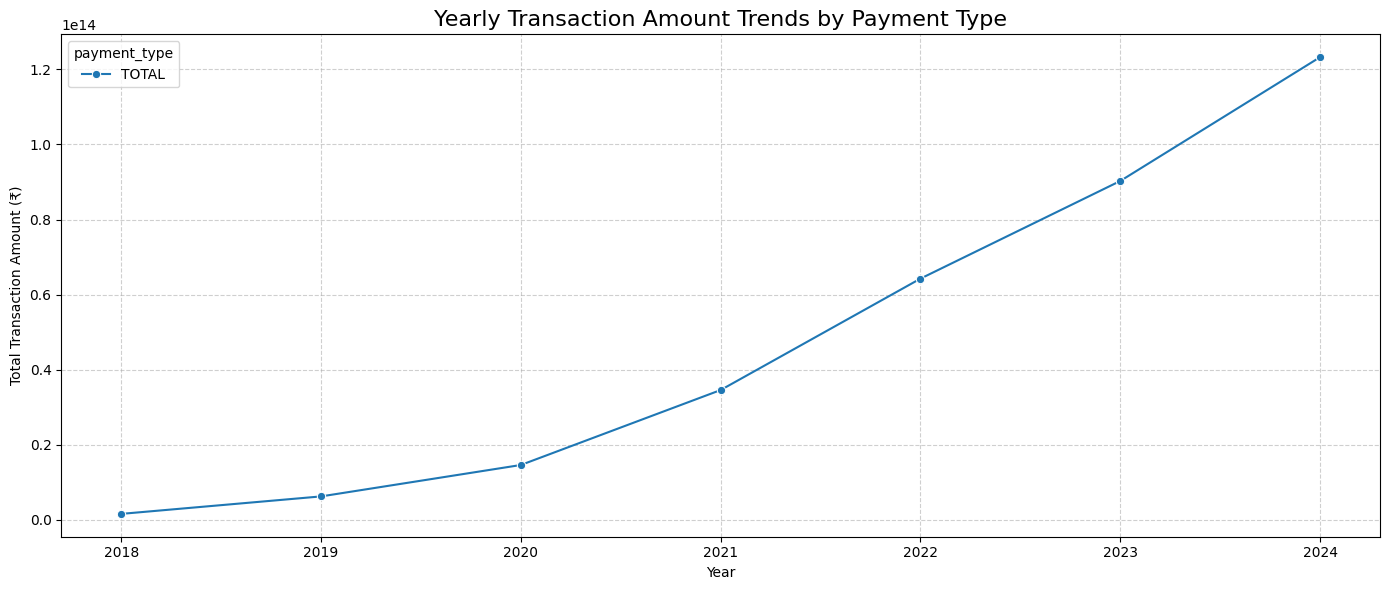

In [5]:
# Group by year and payment_type to see trend
yearly_summary = df_txn_dynamics.groupby(['year', 'payment_type'])['total_amount'].sum().reset_index()

# Plot yearly trend of transaction amount by payment type
plt.figure(figsize=(14,6))
sns.lineplot(data=yearly_summary, x='year', y='total_amount', hue='payment_type', marker='o')
plt.title('Yearly Transaction Amount Trends by Payment Type', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Total Transaction Amount (₹)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Case Study 3: Insurance Penetration

/tmp/ipython-input-8-20630030.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette='Blues_r')


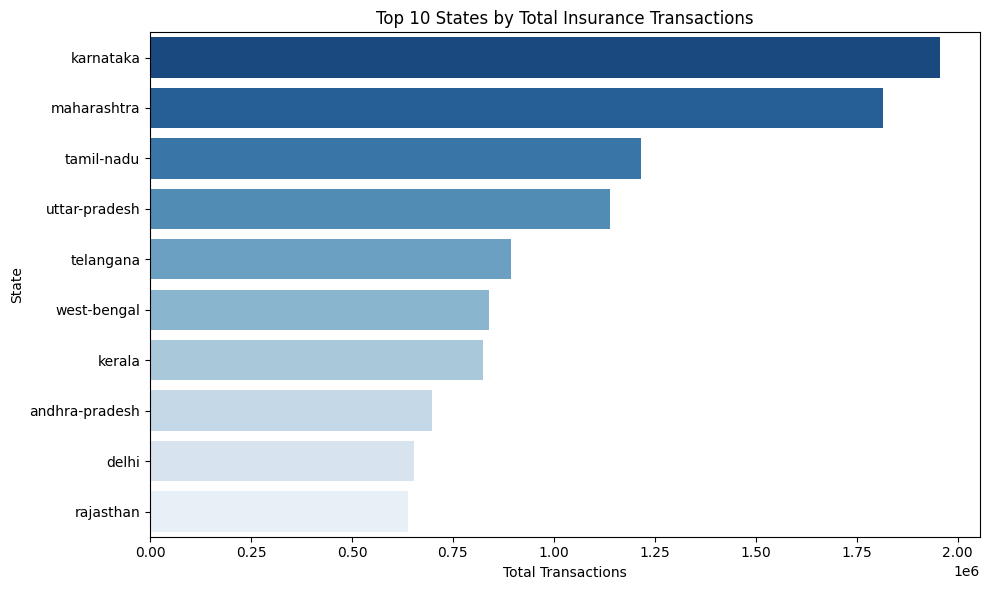

In [8]:
top_states = df_insurance_growth.groupby('state_name')['total_insurance_transactions'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_states.values, y=top_states.index, palette='Blues_r')
plt.title('Top 10 States by Total Insurance Transactions')
plt.xlabel('Total Transactions')
plt.ylabel('State')
plt.tight_layout()
plt.show()


Case Study 4: Market Expansion Analysis
Analysis A – Basic Market Transaction Trends (from case4_market_expansion1.csv)

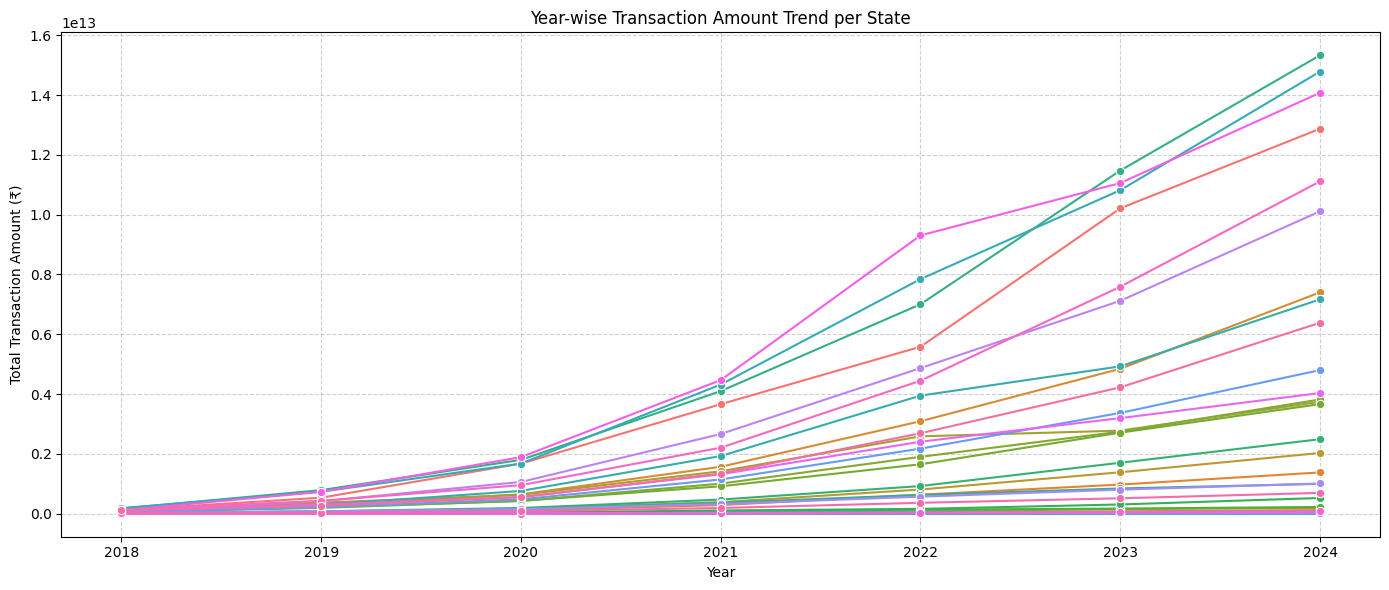

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df_txn_basic = pd.read_csv("case4_market_expansion1.csv")

# Group by year and state to get total amount per year
yearly_amount_by_state = df_txn_basic.groupby(['year', 'state_name'])['total_amount'].sum().reset_index()

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=yearly_amount_by_state, x='year', y='total_amount', hue='state_name', marker='o', legend=False)
plt.title('Year-wise Transaction Amount Trend per State')
plt.xlabel('Year')
plt.ylabel('Total Transaction Amount (₹)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Analysis B – Growth Detection Quarter-over-Quarter (from case4_market_expansion2.csv)

In [15]:
# preparing the data
# Rename columns for clarity
df_txn_growth.rename(columns={
    'total_transactions': 'current_qtr_transactions',
    'previous_quarter_transactions': 'prev_qtr_transactions'
}, inplace=True)

# Calculate Growth %
df_txn_growth['growth_%'] = ((df_txn_growth['current_qtr_transactions'] - df_txn_growth['prev_qtr_transactions']) / df_txn_growth['prev_qtr_transactions']) * 100

# Remove infinite and NaN values
df_txn_growth = df_txn_growth.replace([float("inf"), -float("inf")], pd.NA).dropna(subset=['growth_%'])


/tmp/ipython-input-16-2611765181.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_growth_states, x='growth_%', y='state_name', palette='Greens')


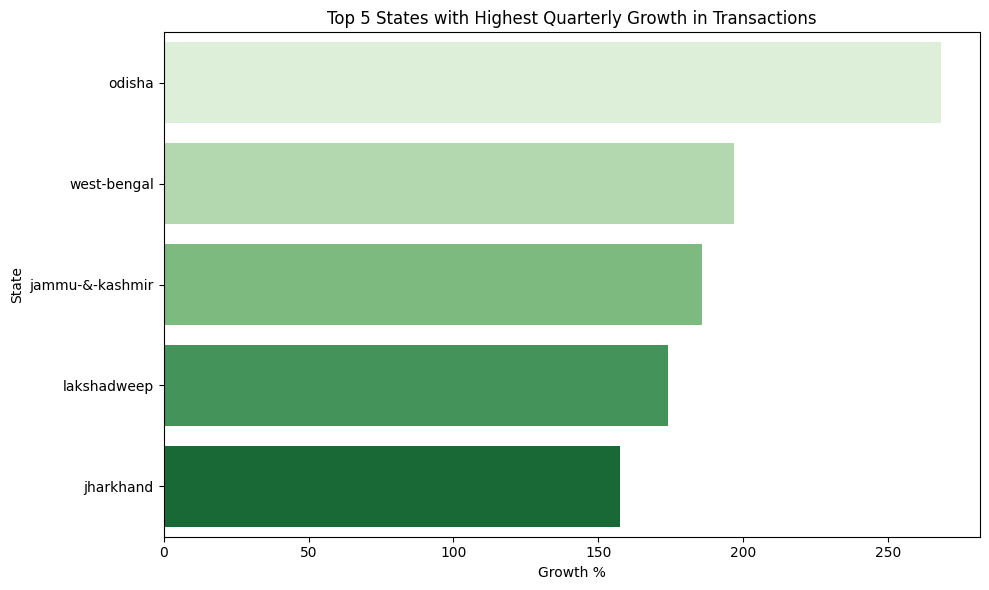

In [16]:
# Top 5 Rapidly Growing States (any quarter)
top_growth_states = df_txn_growth.sort_values('growth_%', ascending=False).drop_duplicates(['state_name']).head(5)

plt.figure(figsize=(10,6))
sns.barplot(data=top_growth_states, x='growth_%', y='state_name', palette='Greens')
plt.title('Top 5 States with Highest Quarterly Growth in Transactions')
plt.xlabel('Growth %')
plt.ylabel('State')
plt.tight_layout()
plt.show()


/tmp/ipython-input-17-2606932314.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decline_summary.values, y=decline_summary.index, palette='Reds')


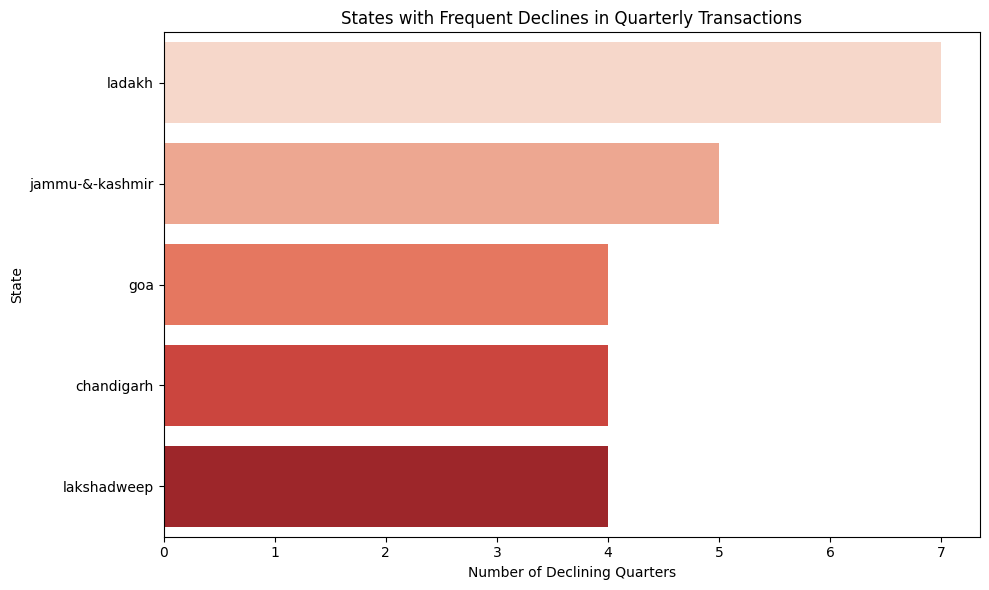

In [17]:
# Consistently Declining States
declining_states = df_txn_growth[df_txn_growth['growth_%'] < 0]
decline_summary = declining_states.groupby('state_name').size().sort_values(ascending=False).head(5)

plt.figure(figsize=(10,6))
sns.barplot(x=decline_summary.values, y=decline_summary.index, palette='Reds')
plt.title('States with Frequent Declines in Quarterly Transactions')
plt.xlabel('Number of Declining Quarters')
plt.ylabel('State')
plt.tight_layout()
plt.show()


In [18]:
# summary
# Export growth summary
df_txn_growth[['state_name', 'year', 'quarter_file', 'current_qtr_transactions', 'prev_qtr_transactions', 'growth_%']]\
    .sort_values('growth_%', ascending=False)\
    .to_csv("case4_growth_summary.csv", index=False)


Case Study 6: Insurance Engagement Trends

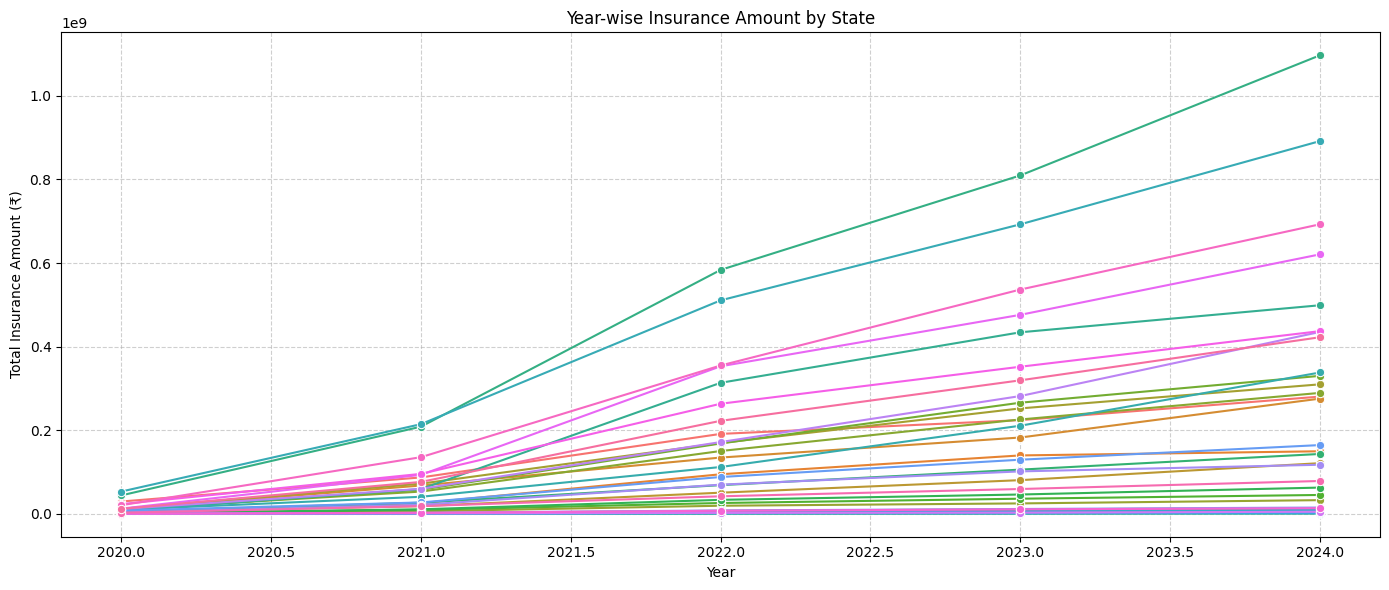

In [21]:
#  Year-wise Insurance Engagement by State
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_insurance_engagement = pd.read_csv("case6_insurance_engagement.csv")

# Group by year and state to get total insurance amount
yearly_insurance_by_state = df_insurance_engagement.groupby(['year', 'state_name'])['total_insurance_amount'].sum().reset_index()

# Plot the year-wise insurance amount trends
plt.figure(figsize=(14,6))
sns.lineplot(data=yearly_insurance_by_state, x='year', y='total_insurance_amount', hue='state_name', marker='o', legend=False)
plt.title('Year-wise Insurance Amount by State')
plt.xlabel('Year')
plt.ylabel('Total Insurance Amount (₹)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



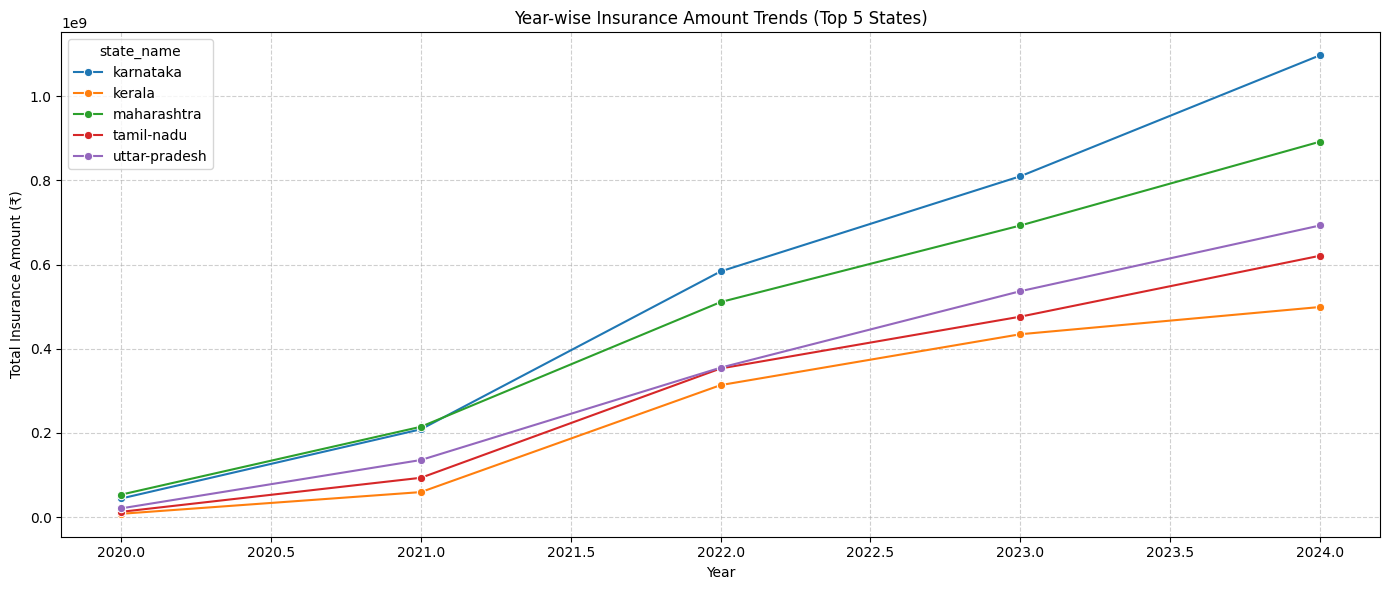

In [20]:
# Top 5 states by total insurance amount
top_states = df_insurance_engagement.groupby('state_name')['total_insurance_amount'].sum().nlargest(5).index

# Filter only top states
filtered_df = df_insurance_engagement[df_insurance_engagement['state_name'].isin(top_states)]

# Group again by year and state
yearly_top_states = filtered_df.groupby(['year', 'state_name'])['total_insurance_amount'].sum().reset_index()

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=yearly_top_states, x='year', y='total_insurance_amount', hue='state_name', marker='o')
plt.title('Year-wise Insurance Amount Trends (Top 5 States)')
plt.xlabel('Year')
plt.ylabel('Total Insurance Amount (₹)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Case Study 7: Top States by Transaction Value

/tmp/ipython-input-22-3230183036.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states_txn.values, y=top_states_txn.index, palette='magma')


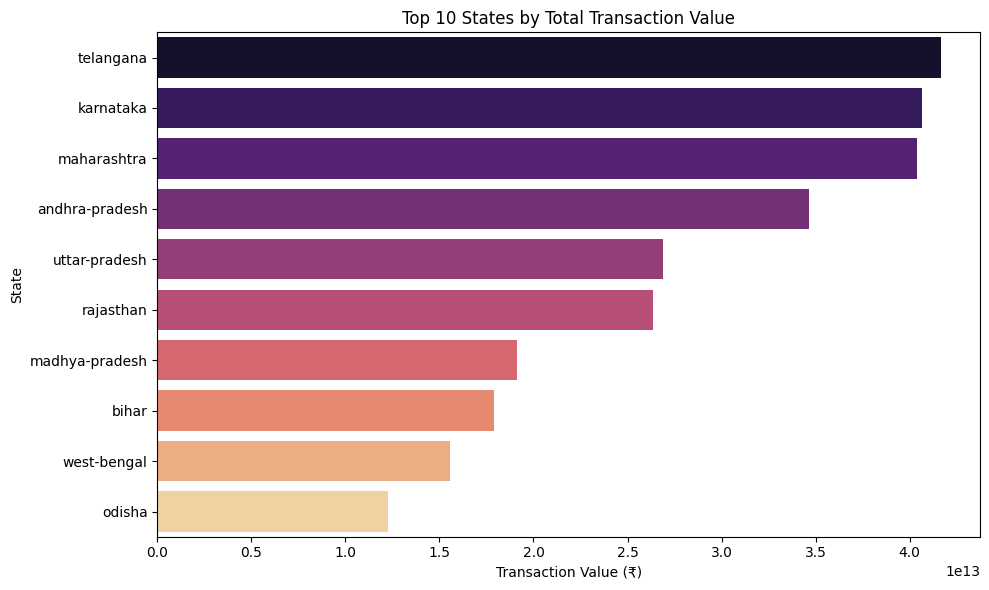

In [22]:
top_states_txn = df_txn_top_states.groupby('state_name')['total_transaction_value'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_states_txn.values, y=top_states_txn.index, palette='magma')
plt.title('Top 10 States by Total Transaction Value')
plt.xlabel('Transaction Value (₹)')
plt.ylabel('State')
plt.tight_layout()
plt.show()


**Streamlit Dashboard**

In [23]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


I wrote streamlit code in python in vs code and uploaded the .py file in colab and file name is phonepe_analysis_app.py

In [24]:
!ls


case1_transaction_dynamics.csv	case6_insurance_engagement.csv
case3_insurance_growth.csv	case7_top_states.csv
case4_growth_summary.csv	phonepe_analysis_app.py
case4_market_expansion1.csv	sample_data
case4_market_expansion2.csv


In [32]:
!pip install pyngrok

In [33]:
from pyngrok import ngrok

# Replace with your own token
ngrok.set_auth_token("cr_2zgHfSIFx5V8UL5ux1SaO3AmA5E")


In [40]:
!pip install streamlit pyngrok --quiet

In [41]:
from pyngrok import ngrok
ngrok.set_auth_token("2zgHfSIFx5V8UL5ux1SaO3AmA5E_6sAXQYJUpJyByKCmDD81s")

In [1]:
import threading
import time
from pyngrok import ngrok

ngrok.kill()

def run():
    !streamlit run phonepe_analysis_app.py

threading.Thread(target=run).start()

time.sleep(10)

public_url = ngrok.connect(8501)
print(f"\n Your app is live at: {public_url}")





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8504
  Network URL: http://172.28.0.12:8504
  External URL: http://34.91.226.149:8504


 Your app is live at: NgrokTunnel: "https://0c48ddbbdd8a.ngrok-free.app" -> "http://localhost:8501"
